In [124]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [125]:
data = pd.read_csv('ar41_with_weather_mini.csv', delimiter=';')

In [126]:
# Select the relevant columns for clustering
features = ['RS_E_InAirTemp_PC1', 'RS_E_InAirTemp_PC2', 'RS_E_OilPress_PC1',
            'RS_E_OilPress_PC2', 'RS_E_RPM_PC1', 'RS_E_RPM_PC2', 'RS_E_WatTemp_PC1',
            'RS_E_WatTemp_PC2', 'RS_T_OilTemp_PC1', 'RS_T_OilTemp_PC2', 'temperature',
            'precipitation', 'windspeed_10m', 'sum_pollen']


# drop timestamp feature
data = data.drop(columns=['timestamps_UTC'])

# Extract the selected features from the DataFrame
X = data[features]

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of

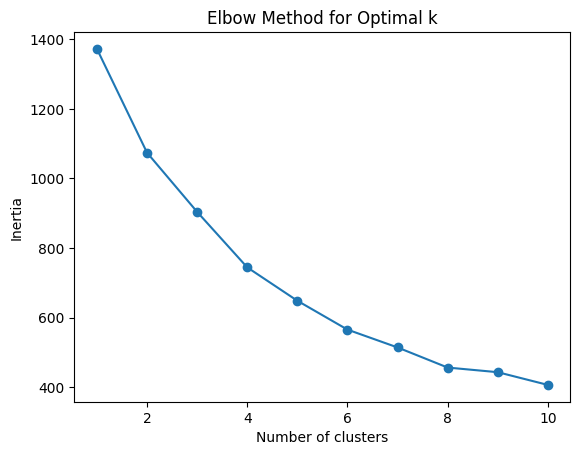

In [127]:
# Find the optimal number of clusters using the Elbow method
inertia = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Plot the Elbow curve
import matplotlib.pyplot as plt
plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()


In [128]:
# Choose an appropriate number of clusters (k) based on the Elbow curve
k = 5  # Adjust this value based on the Elbow curve

# Fit the K-means model
kmeans = KMeans(n_clusters=k, random_state=0)
kmeans.fit(X_scaled)


/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=5, random_state=0)

In [129]:
# Add cluster labels to the original DataFrame
data['cluster'] = kmeans.labels_

# Calculate the distance of each point to its assigned cluster center
data['distance_to_center'] = np.min(kmeans.transform(X_scaled), axis=1)

# Set a threshold for anomaly detection (e.g., based on a percentile of distances)
threshold = np.percentile(data['distance_to_center'], 95)

# Identify anomalies by comparing distances to the threshold
anomalies = data[data['distance_to_center'] > threshold]

# You can now analyze the 'anomalies' DataFrame to identify potential anomalies in your train data


In [130]:
anomalies

,mapped_veh_id,lat,lon,RS_E_InAirTemp_PC1,RS_E_InAirTemp_PC2,RS_E_OilPress_PC1,RS_E_OilPress_PC2,RS_E_RPM_PC1,RS_E_RPM_PC2,RS_E_WatTemp_PC1,RS_E_WatTemp_PC2,RS_T_OilTemp_PC1,RS_T_OilTemp_PC2,temperature,precipitation,windspeed_10m,sum_pollen,cluster,distance_to_center
39,170,50.855130,3.606150,27.0,25.0,407.0,503.0,800.0,802.0,51.0,42.0,42.0,41.0,25.6,0.0,12.7,3.7,2,5.964339
79,128,51.190872,5.115277,29.0,38.0,255.0,272.0,833.0,802.0,79.0,58.0,77.0,64.0,19.3,0.8,25.7,12.7,3,3.984544
88,182,51.035844,3.709814,23.0,31.0,207.0,207.0,799.0,798.0,78.0,76.0,77.0,75.0,18.6,1.1,13.0,4.6,3,3.735469
90,122,51.180327,3.575733,37.0,29.0,189.0,251.0,820.0,802.0,78.0,80.0,78.0,0.0,18.6,1.1,13.0,4.6,2,6.366531
91,181,51.179293,4.824000,40.0,37.0,217.0,203.0,802.0,797.0,84.0,86.0,87.0,92.0,18.5,2.1,11.3,4.0,1,6.256111


In [131]:
# Assuming you have already fitted the K-means model and added cluster labels to your DataFrame
max_temp_air = 65
max_temp_water = 100
max_temp_oil = 115

min_temp = 2

# Get cluster centroids
cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)

# Create a DataFrame to hold the cluster centroids
cluster_centroids_df = pd.DataFrame(cluster_centers, columns=features)

# You can now analyze the cluster centroids to identify abnormal conditions
# For example, you can check if any of the cluster centroids have values outside of acceptable ranges for your features.

# Define acceptable ranges for each feature
acceptable_ranges = {
    'RS_E_InAirTemp_PC1': (min_temp, max_temp_air),
    'RS_E_InAirTemp_PC2': (min_temp, max_temp_air),
    #'RS_E_WatTemp_PC1': (min_temp, max_temp_water),
    #'RS_E_WatTemp_PC2': (min_temp, max_temp_water),
    #'RS_T_OilTemp_PC1': (min_temp, max_temp_oil),
    #'RS_T_OilTemp_PC2': (min_temp, max_temp_oil),
    # Add acceptable ranges for other features
}

# Check for clusters with centroids outside acceptable ranges
abnormal_clusters = []
for cluster_idx, centroid in enumerate(cluster_centers):
    is_abnormal = False
    for feature, (min_value, max_value) in acceptable_ranges.items():
        if centroid[features.index(feature)] < min_value or centroid[features.index(feature)] > max_value:
            is_abnormal = True
            break
    if is_abnormal:
        abnormal_clusters.append(cluster_idx)

# The 'abnormal_clusters' list now contains the cluster indices that represent abnormal train conditions.
abnormal_clusters

[4]

In [132]:
abnormal_clusters

[4]

In [133]:
data[data['cluster'] == 4]

,mapped_veh_id,lat,lon,RS_E_InAirTemp_PC1,RS_E_InAirTemp_PC2,RS_E_OilPress_PC1,RS_E_OilPress_PC2,RS_E_RPM_PC1,RS_E_RPM_PC2,RS_E_WatTemp_PC1,RS_E_WatTemp_PC2,RS_T_OilTemp_PC1,RS_T_OilTemp_PC2,temperature,precipitation,windspeed_10m,sum_pollen,cluster,distance_to_center
63,194,50.784013,3.619873,0.0,44.0,148.0,351.000000,829.5,1603.500000,0.0,89.0,81.500000,87.0,23.5,0.0,9.4,7.0,4,3.174050
71,194,51.035433,3.711526,0.0,41.0,0.0,210.000000,0.0,802.000000,0.0,84.0,75.000000,82.0,21.8,0.3,7.4,5.8,4,1.549315
72,194,51.035310,3.712176,0.0,38.0,0.0,213.333333,0.0,799.666667,0.0,83.0,73.666667,82.0,21.8,0.3,7.4,5.8,4,1.675938


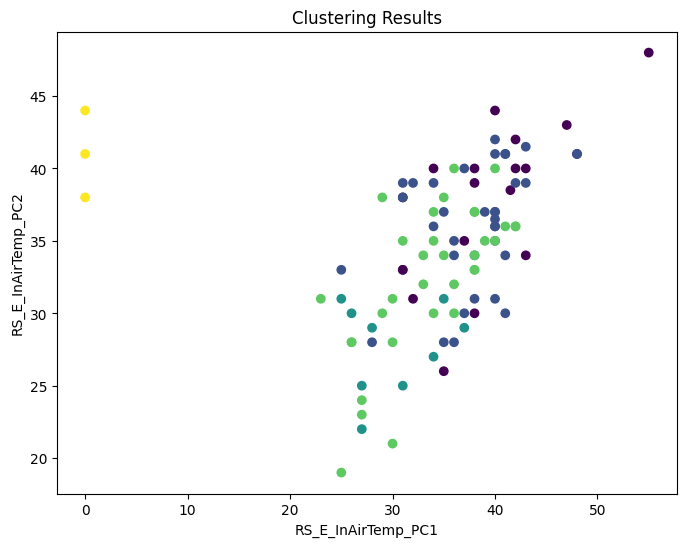

In [134]:
feature1 = 'RS_E_InAirTemp_PC1'
feature2 = 'RS_E_InAirTemp_PC2'

plt.figure(figsize=(8, 6))
plt.scatter(data[feature1], data[feature2], c=data['cluster'], cmap='viridis')
plt.title('Clustering Results')
plt.xlabel(feature1)
plt.ylabel(feature2)
plt.show()